# Generating MNIST adversarial examples with AdvDCGAN

In [ ]:
!pip install tensorflow-io==0.25.0

!pip install git+https://github.com/tensorflow/docs
!pip install git+https://github.com/tensorflow/examples.git

In [ ]:
import os
import time

import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf

from tensorflow_examples.models.dcgan import dcgan

from callbacks import ImageAdvGANCallback
from losses import carlini_wagner_loss_fn, l2_norm_soft_hinge_loss_fn
from models.advgan import AdvGAN
from models.target import MNISTConvTarget

from util import (
    images_to_gif,
    generate_adv_examples,
    plot_image_results,
    plot_confusion_matrix
)

In [ ]:
IMAGES_DIR = 'images'
WEIGHTS_DIR = 'weights'

BASE_FILENAME = 'advdcgan_mnist'

In [ ]:
if not os.path.isdir(IMAGES_DIR):
    os.makedirs(IMAGES_DIR)

if not os.path.isdir(WEIGHTS_DIR):
    os.makedirs(WEIGHTS_DIR)

In [ ]:
TARGET_LABEL = 3  # the chosen label for the targeted attack

BUFFER_SIZE = 60000
BATCH_SIZE = 128

INPUT_SHAPE = (28, 28, 1)

LATENT_DIM = 100

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-b9c581d0-cb7b-f112-cb62-6833345ec748)


## Data loading and preprocessing

Load the MNIST training set images:

In [ ]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

print(f'training set: {train_images.shape}, {train_labels.shape}')
print(f'test set: {test_images.shape}, {test_labels.shape}')

training set: (60000, 28, 28), (60000,)
test set: (10000, 28, 28), (10000,)


Filter out the `TARGET_LABEL` samples, reshape the images to $28 \times 28 \times 1$ and normalize them to $[-1, 1]$:

In [ ]:
def filter(images, labels):
    target_filter = (labels != TARGET_LABEL)
    
    return images[target_filter], labels[target_filter]

In [ ]:
def reshape(images, labels):
    return images.reshape(images.shape[0], *INPUT_SHAPE).astype('float32'), labels

In [ ]:
def normalize(images, labels):
    return (images - 127.5) / 127.5, labels

In [ ]:
def preprocess(images, labels):
    return normalize(*reshape(*filter(images, labels)))

In [ ]:
train_images, train_labels = preprocess(train_images, train_labels)
test_images, test_labels = preprocess(test_images, test_labels)

Shuffle and batch the training set data:

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## AdvDCGAN

AdvDCGAN is a [DCGAN](https://arxiv.org/abs/1511.06434)-based model for creating adversarial examples.

It consists of three parts: the generator, the discriminator, and the target of the adversarial attacks.

The generator creates the adversarial perturbations from random noise vectors, while the discriminator tries to distinguish between the original images and the adversarial images.

The target network is used for computing the adversarial loss, which guides the generator during training towards creating more successful adversarial images.

### Generator

The generator receives a random noise vector as input and shapes it into an adversarial perturbation of the desired size ($28 \times 28 \times 1$ for MNIST) using upsampling layers (`tf.keras.layers.Conv2DTranspose`).

Import the model from the [DCGAN](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/dcgan/dcgan.py) implementation in the installed [tensorflow_examples](https://github.com/tensorflow/examples) package:

In [ ]:
generator = dcgan.make_generator_model()

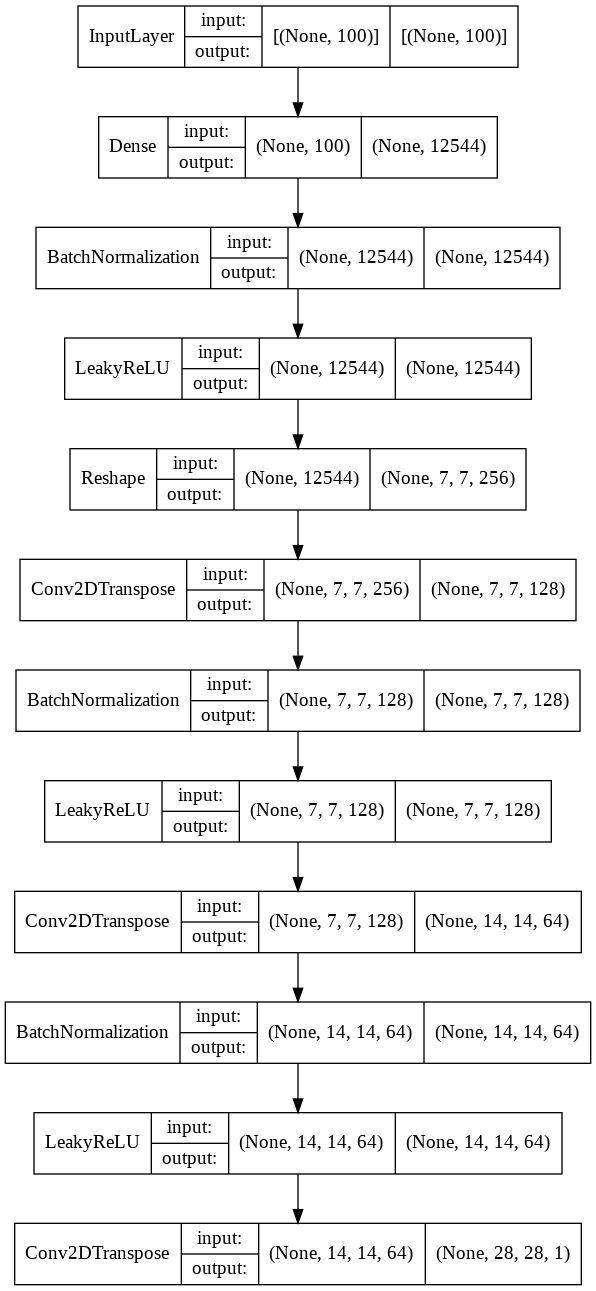

In [ ]:
generator.build((None, LATENT_DIM))
tf.keras.utils.plot_model(generator, show_shapes=True, show_layer_names=False)

### Discriminator

The discriminator is a CNN-based binary classifier whose task is to differentiate between real images (from the training set) and adversarial images (created by the generator).

Import the model from the [DCGAN](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/dcgan/dcgan.py) implementation in the installed [tensorflow_examples](https://github.com/tensorflow/examples) package:

In [ ]:
discriminator = dcgan.make_discriminator_model()

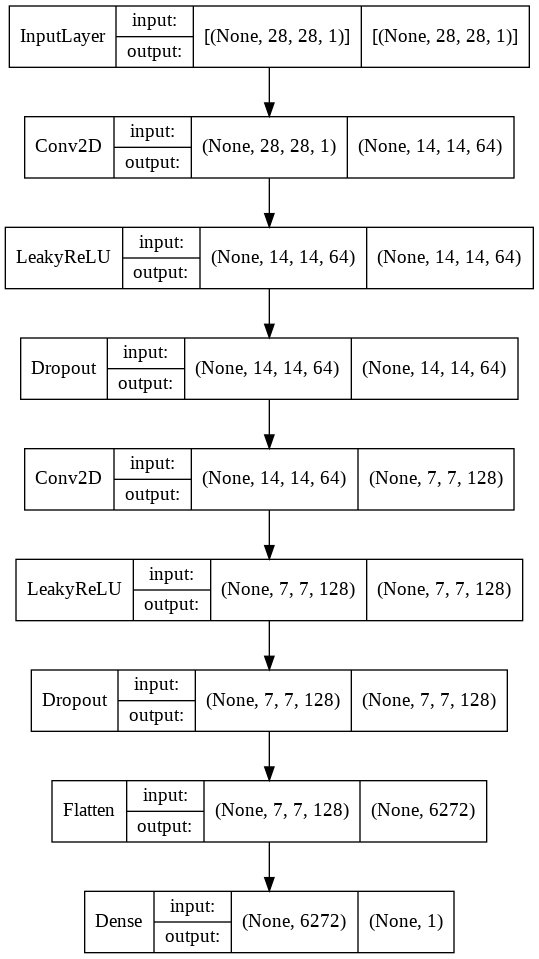

In [ ]:
discriminator.build((None, *INPUT_SHAPE))
tf.keras.utils.plot_model(discriminator, show_shapes=True, show_layer_names=False)

### Target

The pre-trained `MNISTConvTarget` model is the target of the attacks.
It is used for computing the adversarial loss, which guides the generator during training.

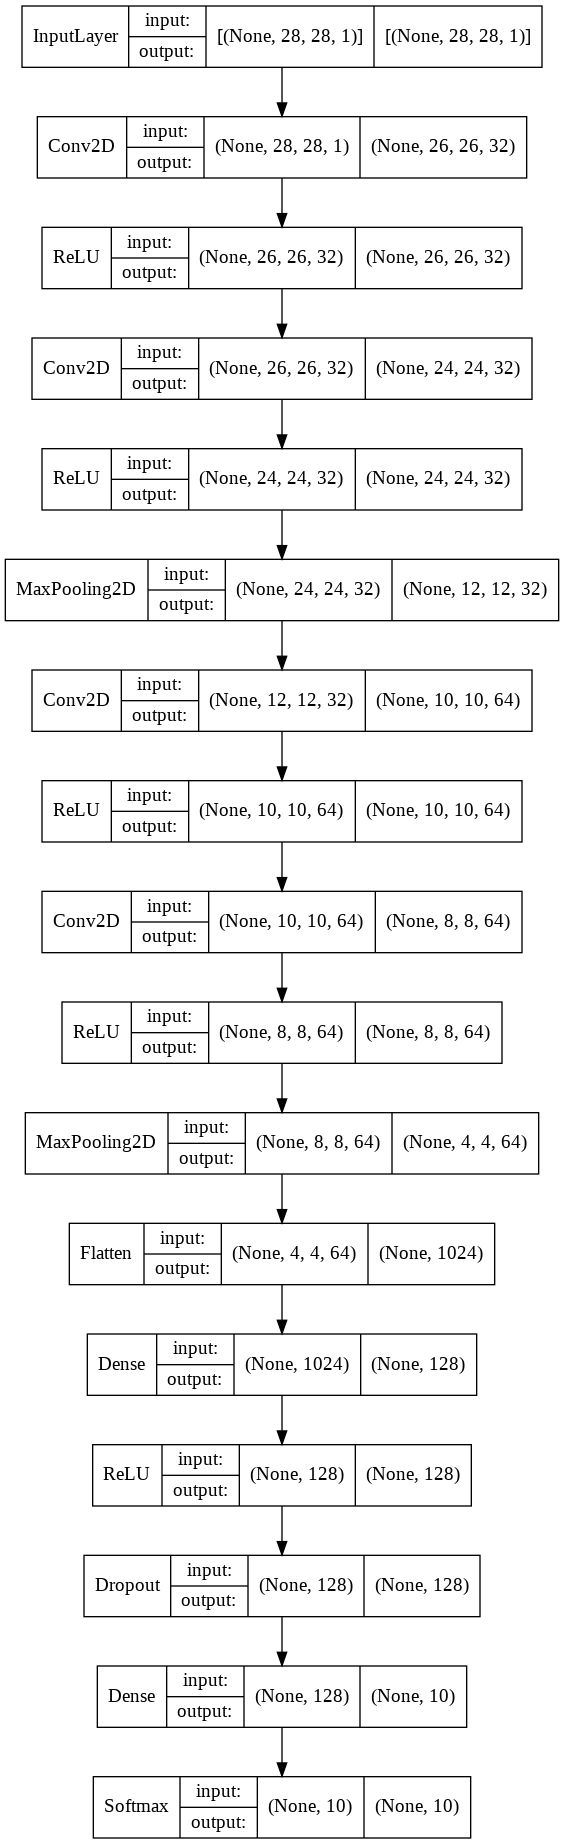

In [ ]:
target = MNISTConvTarget()
tf.keras.utils.plot_model(target.model, show_shapes=True, show_layer_names=False)

In [ ]:
weights_path = f'{WEIGHTS_DIR}/mnist_conv_target_20220106120545.h5'

target.built = True
target.load_weights(weights_path)

### Training

In each training step, the generator receives a batch of random noise vectors $\mathbf{z}$ as input and uses it to generate a batch of adversarial perturbations $G(\mathbf{z})$.

The adversarial images are obtained by combining the training set images with the perturbations: $\mathbf{x}_{adv} = \mathbf{x} + G(\mathbf{z})$ (making sure that the values remain in $[-1, 1]$).

The target model classifies the adversarial images, and the resulting class probabilities $f(\mathbf{x}_{adv})$ are used for calculating the adversarial loss.

Then, the discriminator classifies the real images (from the training set) and adversarial images (produced by the generator).

The loss is calculated for the discriminator and the generator respectively, and the resulting gradients are used to update them.

#### Discriminator loss

The discriminator's loss quantifies how well it distinguishes between real images $\mathbf{x}$ and generated images $\mathbf{x} + G(\mathbf{z})$.
As such, it is a sum of the losses computed on the real and fake outputs, respectively:

$\mathcal{L}_D = \mathcal{L_{D,\mathrm{real}}} + \mathcal{L_{D,\mathrm{fake}}}$

For the real component, the discriminator's predictions are compared to an array of 1s, and for the fake outputs to an array of 0s:

$\mathcal{L_{D,\mathrm{real}}} = BCE(\mathbf{1}, D(\mathbf{x}))$

$\mathcal{L_{D,\mathrm{fake}}} = BCE(\mathbf{0}, D(\mathbf{x} + G(\mathbf{z})))$,

where $BCE$ stands for the binary cross-entropy loss function.

#### Generator loss

In the adversarial attack setting, the generator loss $\mathcal{L}_G$, besides quantifying how well the generator fools the discriminator, also needs to quantify the successfulness of the generated adversarial images (i.e. how well do they fool the target into classifying them as the desired target label $t$).

The adversarial component of the loss is calculated according to the formula found in [Carlini and Wagner (2017b)](https://nicholas.carlini.com/papers/2017_sp_nnrobustattacks.pdf).
For a single adversarial image $x_{adv}$ and the corresponding class probabilities obtained from the target model $f(x_{adv})$, the adversarial loss is calculated as:

$\mathcal{L_{x_{adv}}} = \mathrm{max}(\mathrm{max}_{i \ne t} f(x_{adv})_i - f(x_{adv})_t,\ 0)$

Since we are training on batches of data, the final adversarial loss $\mathcal{L_{adv}}$ is a sum of all the individual adversarial losses for the adversarial images generated in the batch.

Additionally, a soft hinge loss on the L2 norm of the perturbations is added to bound their magnitude. For a single adversarial perturbation:

$\mathcal{L}_{perturb, z} = \mathrm{max}(||G(z)||_2 - \mathrm{bound}, 0)$,

where $\mathrm{bound}$ is a user-specified parameter (e.g. $0.3$).
Again, because we are dealing with batched data, the final perturbation loss $\mathcal{L}_{perturb}$ is a mean of all the individual perturbation losses for the batch.

The total generator loss is then:

$\mathcal{L}_G = \mathcal{L_{adv}} + \lambda_{gan}BCE(\mathbf{1}, D(\mathbf{x} + G(\mathbf{z}))) + \lambda_{perturb}\mathcal{L}_{perturb}$,

where $\lambda_{gan}$ and $\lambda_{perturb}$ are user-defined parameters that control the importance of the original generator loss and perturbation loss respectively.

Create the AdvDCGAN model:

In [ ]:
advdcgan = AdvGAN(
    target=target,
    discriminator=discriminator,
    generator=generator,
    latent_dim=LATENT_DIM
)

Compile the model by adding the respective optimizers (two are needed because the discriminator and generator train separately), the base loss function, the adversarial loss function, the $\lambda$ parameters, and the optional $L_∞$ perturbation bound.

Note that `from_logits` needs to be set to `True` as the discriminator outputs logits instead of probabilities.

In [ ]:
PERTURB_BOUND = None

advdcgan.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002),

    loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True, label_smoothing=0.1),
    adv_loss_fn=carlini_wagner_loss_fn(target_label=TARGET_LABEL),
    perturb_loss_fn=l2_norm_soft_hinge_loss_fn(bound=0.1),

    lambda_gan=1,
    lambda_perturb=1,
    perturb_bound=PERTURB_BOUND
)

Create a callback that periodically saves generated images:

In [ ]:
callback = ImageAdvGANCallback(
    train_images[:5],
    path_prefix=f'{IMAGES_DIR}/{BASE_FILENAME}',
    latent_dim=LATENT_DIM,
    perturb_bound=PERTURB_BOUND
)

Finally, train the model:

Epoch 1/50
421/421 [==============================] - ETA: 0s - d_loss: 0.2287 - g_loss: 33.2388 - g_gan_loss: 2.7417 - g_adv_loss: 12.3368 - g_perturb_loss: 18.1603

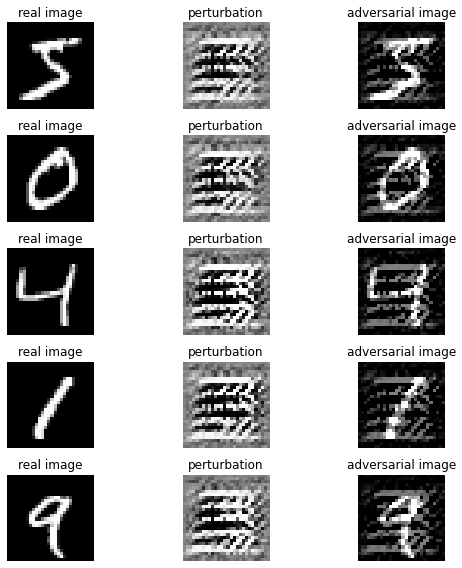

421/421 [==============================] - 25s 48ms/step - d_loss: 0.2287 - g_loss: 33.2072 - g_gan_loss: 2.7419 - g_adv_loss: 12.3076 - g_perturb_loss: 18.1577
Epoch 2/50
421/421 [==============================] - ETA: 0s - d_loss: 0.2020 - g_loss: 20.7582 - g_gan_loss: 2.8604 - g_adv_loss: 1.4222 - g_perturb_loss: 16.4757

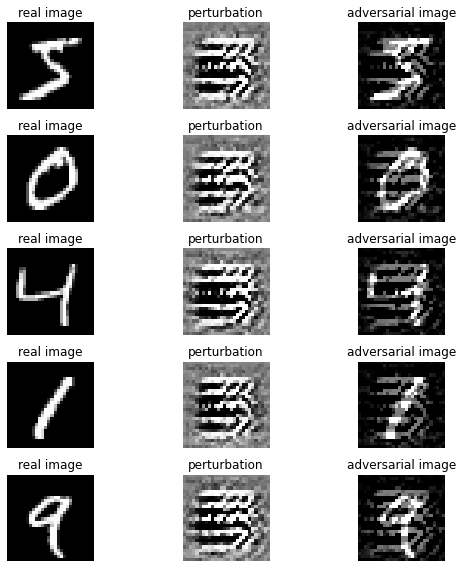

421/421 [==============================] - 18s 41ms/step - d_loss: 0.2020 - g_loss: 20.7546 - g_gan_loss: 2.8602 - g_adv_loss: 1.4197 - g_perturb_loss: 16.4747
Epoch 3/50
421/421 [==============================] - ETA: 0s - d_loss: 0.2023 - g_loss: 19.6771 - g_gan_loss: 2.8644 - g_adv_loss: 1.2695 - g_perturb_loss: 15.5433

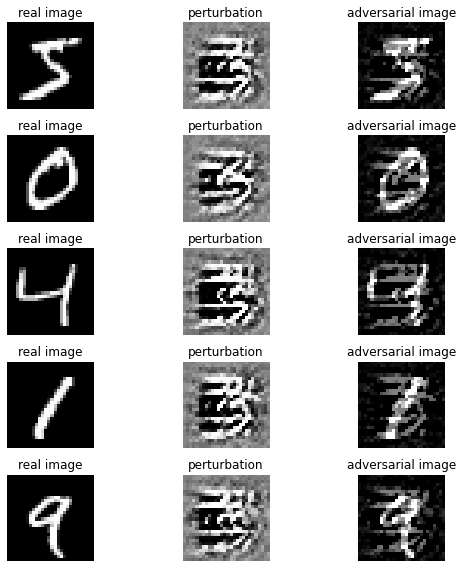

421/421 [==============================] - 18s 41ms/step - d_loss: 0.2023 - g_loss: 19.6740 - g_gan_loss: 2.8643 - g_adv_loss: 1.2668 - g_perturb_loss: 15.5430
Epoch 4/50
421/421 [==============================] - ETA: 0s - d_loss: 0.2023 - g_loss: 18.9952 - g_gan_loss: 2.8653 - g_adv_loss: 1.0191 - g_perturb_loss: 15.1108

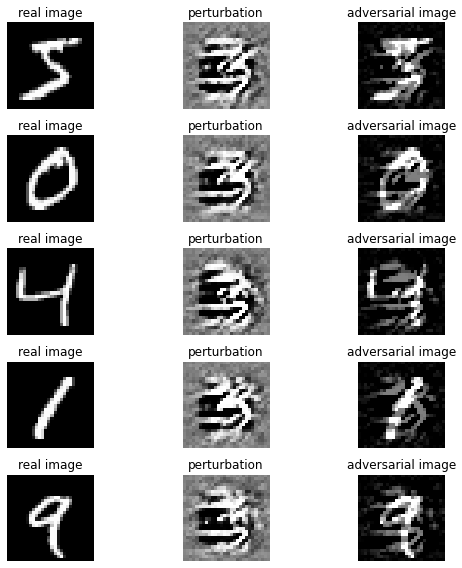

421/421 [==============================] - 17s 41ms/step - d_loss: 0.2023 - g_loss: 18.9935 - g_gan_loss: 2.8653 - g_adv_loss: 1.0184 - g_perturb_loss: 15.1099
Epoch 5/50
421/421 [==============================] - ETA: 0s - d_loss: 0.2029 - g_loss: 18.5575 - g_gan_loss: 2.8664 - g_adv_loss: 1.0152 - g_perturb_loss: 14.6759

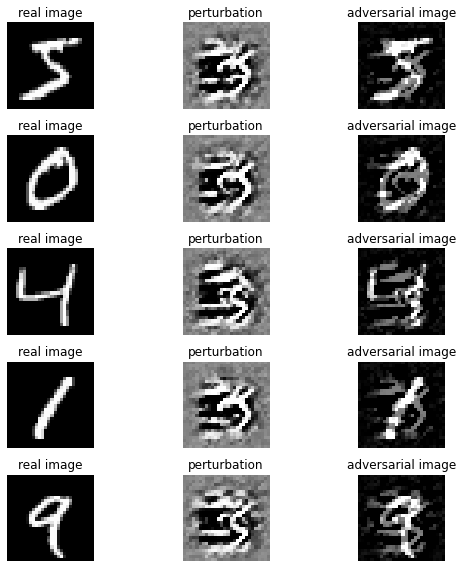

421/421 [==============================] - 17s 41ms/step - d_loss: 0.2029 - g_loss: 18.5549 - g_gan_loss: 2.8664 - g_adv_loss: 1.0128 - g_perturb_loss: 14.6757
Epoch 6/50
421/421 [==============================] - ETA: 0s - d_loss: 0.2030 - g_loss: 18.1500 - g_gan_loss: 2.8631 - g_adv_loss: 0.9583 - g_perturb_loss: 14.3285

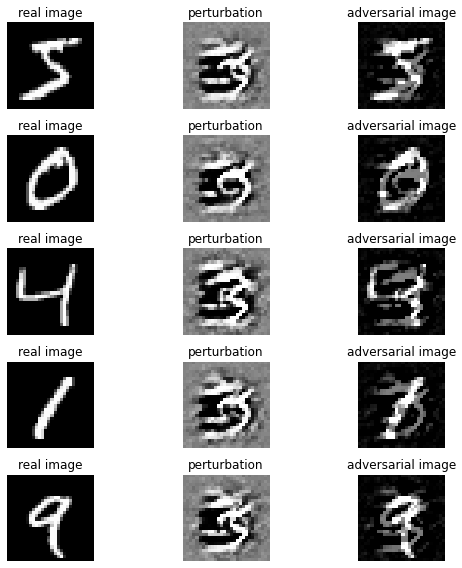

421/421 [==============================] - 17s 41ms/step - d_loss: 0.2030 - g_loss: 18.1496 - g_gan_loss: 2.8632 - g_adv_loss: 0.9579 - g_perturb_loss: 14.3285
Epoch 7/50
421/421 [==============================] - ETA: 0s - d_loss: 0.2027 - g_loss: 17.9647 - g_gan_loss: 2.8625 - g_adv_loss: 0.9367 - g_perturb_loss: 14.1655

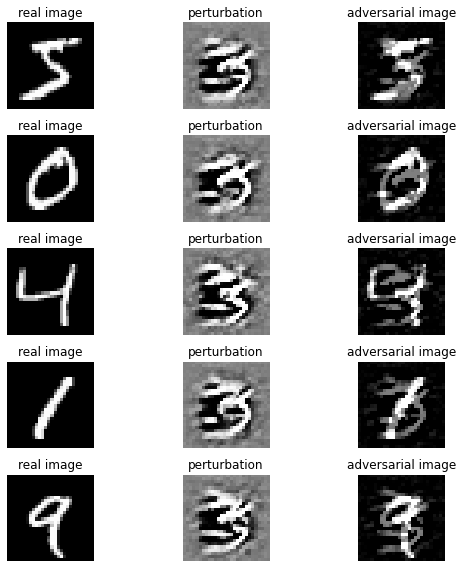

421/421 [==============================] - 17s 41ms/step - d_loss: 0.2027 - g_loss: 17.9621 - g_gan_loss: 2.8626 - g_adv_loss: 0.9344 - g_perturb_loss: 14.1651
Epoch 8/50
421/421 [==============================] - ETA: 0s - d_loss: 0.2025 - g_loss: 17.6489 - g_gan_loss: 2.8616 - g_adv_loss: 0.8973 - g_perturb_loss: 13.8900

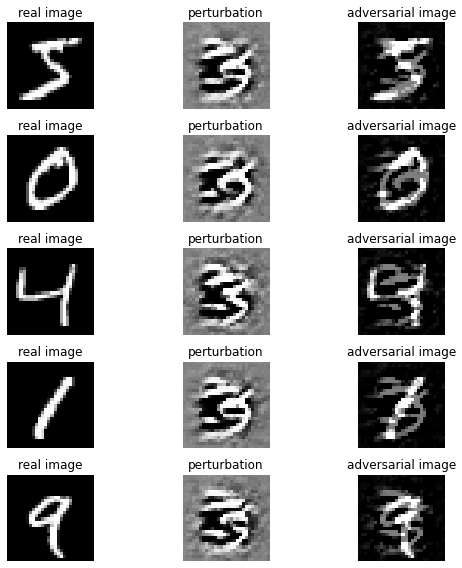

421/421 [==============================] - 18s 42ms/step - d_loss: 0.2025 - g_loss: 17.6470 - g_gan_loss: 2.8616 - g_adv_loss: 0.8954 - g_perturb_loss: 13.8900
Epoch 9/50
421/421 [==============================] - ETA: 0s - d_loss: 0.2024 - g_loss: 17.3882 - g_gan_loss: 2.8582 - g_adv_loss: 0.8180 - g_perturb_loss: 13.7120

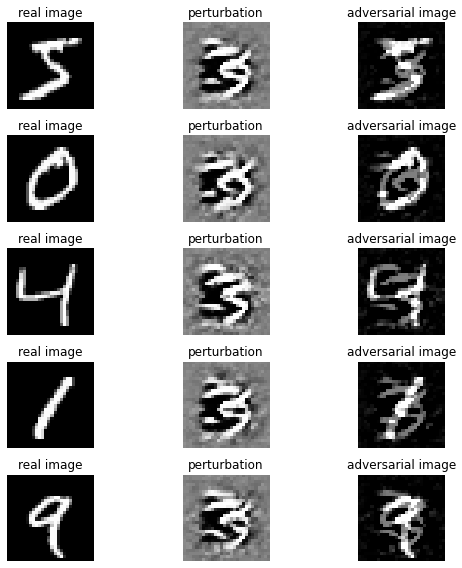

421/421 [==============================] - 18s 41ms/step - d_loss: 0.2024 - g_loss: 17.3874 - g_gan_loss: 2.8581 - g_adv_loss: 0.8176 - g_perturb_loss: 13.7118
Epoch 10/50
421/421 [==============================] - ETA: 0s - d_loss: 0.2022 - g_loss: 17.1769 - g_gan_loss: 2.8609 - g_adv_loss: 0.8219 - g_perturb_loss: 13.4941

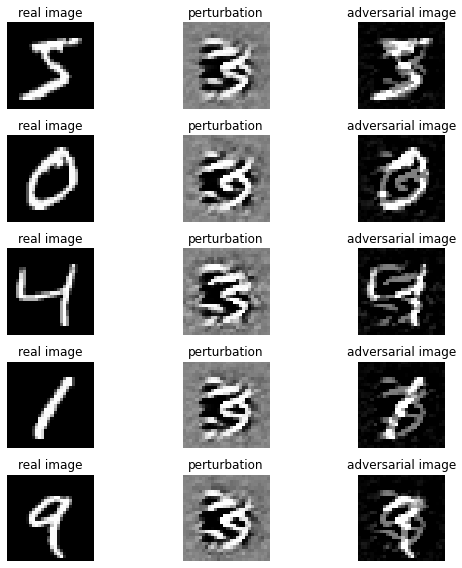

421/421 [==============================] - 17s 41ms/step - d_loss: 0.2022 - g_loss: 17.1764 - g_gan_loss: 2.8609 - g_adv_loss: 0.8216 - g_perturb_loss: 13.4939
Epoch 11/50
421/421 [==============================] - ETA: 0s - d_loss: 0.2019 - g_loss: 16.8861 - g_gan_loss: 2.8592 - g_adv_loss: 0.7828 - g_perturb_loss: 13.2441

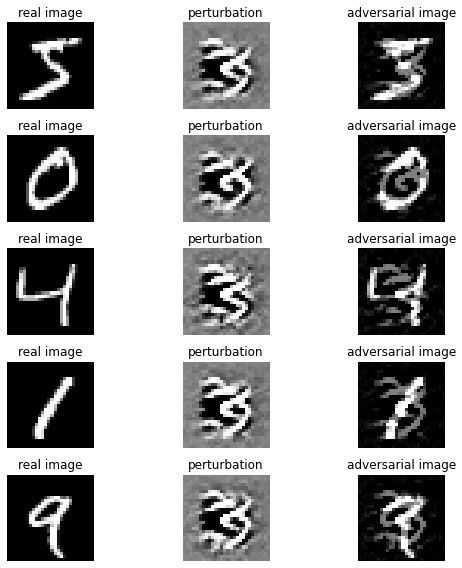

421/421 [==============================] - 18s 42ms/step - d_loss: 0.2019 - g_loss: 16.8848 - g_gan_loss: 2.8591 - g_adv_loss: 0.7813 - g_perturb_loss: 13.2444
Epoch 12/50
421/421 [==============================] - ETA: 0s - d_loss: 0.2021 - g_loss: 16.6679 - g_gan_loss: 2.8585 - g_adv_loss: 0.8011 - g_perturb_loss: 13.0083

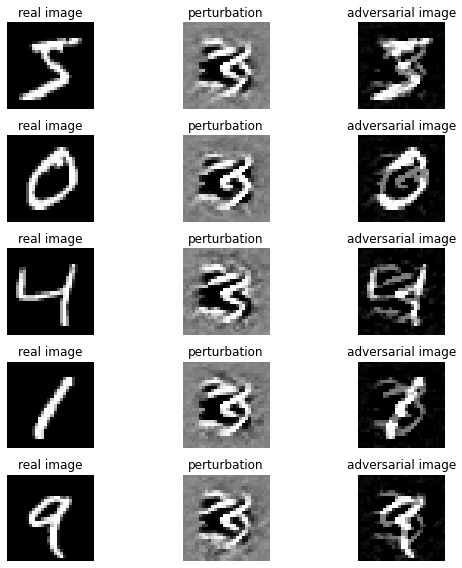

421/421 [==============================] - 18s 42ms/step - d_loss: 0.2021 - g_loss: 16.6677 - g_gan_loss: 2.8586 - g_adv_loss: 0.8009 - g_perturb_loss: 13.0082
Epoch 13/50
421/421 [==============================] - ETA: 0s - d_loss: 0.2020 - g_loss: 16.5926 - g_gan_loss: 2.8605 - g_adv_loss: 0.7237 - g_perturb_loss: 13.0084

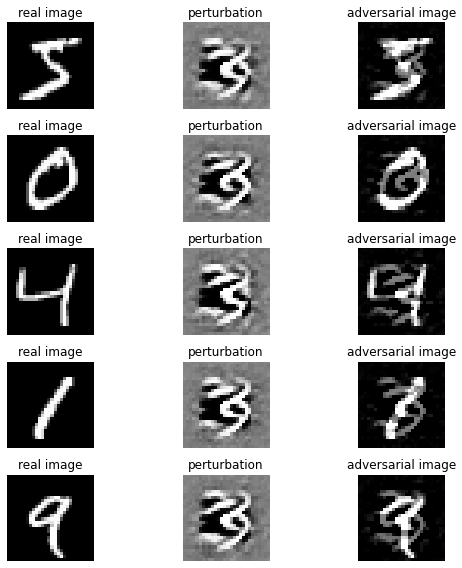

421/421 [==============================] - 17s 41ms/step - d_loss: 0.2020 - g_loss: 16.5906 - g_gan_loss: 2.8601 - g_adv_loss: 0.7220 - g_perturb_loss: 13.0086
Epoch 14/50
421/421 [==============================] - ETA: 0s - d_loss: 0.2017 - g_loss: 16.5723 - g_gan_loss: 2.8598 - g_adv_loss: 0.8435 - g_perturb_loss: 12.8689

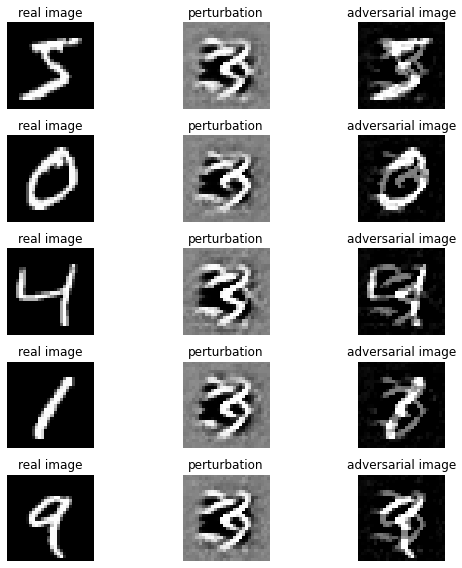

421/421 [==============================] - 18s 42ms/step - d_loss: 0.2017 - g_loss: 16.5745 - g_gan_loss: 2.8598 - g_adv_loss: 0.8454 - g_perturb_loss: 12.8693
Epoch 15/50
420/421 [============================>.] - ETA: 0s - d_loss: 0.2016 - g_loss: 16.4440 - g_gan_loss: 2.8609 - g_adv_loss: 0.7335 - g_perturb_loss: 12.8497

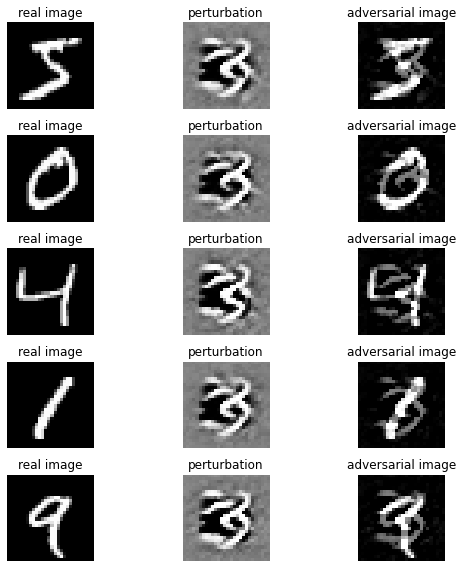

421/421 [==============================] - 18s 42ms/step - d_loss: 0.2016 - g_loss: 16.4429 - g_gan_loss: 2.8611 - g_adv_loss: 0.7327 - g_perturb_loss: 12.8492
Epoch 16/50
421/421 [==============================] - ETA: 0s - d_loss: 0.2012 - g_loss: 16.2447 - g_gan_loss: 2.8589 - g_adv_loss: 0.7086 - g_perturb_loss: 12.6772

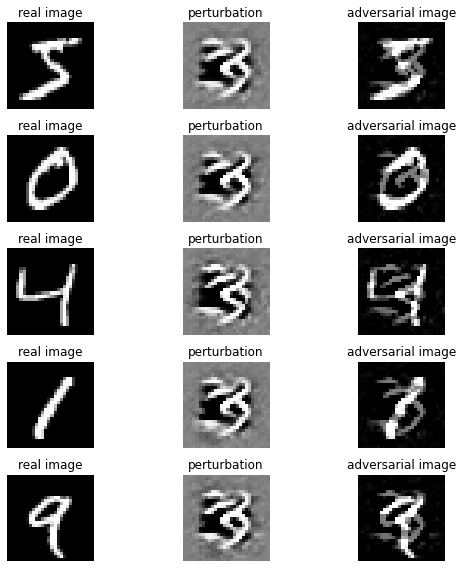

421/421 [==============================] - 18s 42ms/step - d_loss: 0.2012 - g_loss: 16.2459 - g_gan_loss: 2.8587 - g_adv_loss: 0.7101 - g_perturb_loss: 12.6772
Epoch 17/50
420/421 [============================>.] - ETA: 0s - d_loss: 0.2013 - g_loss: 16.2379 - g_gan_loss: 2.8571 - g_adv_loss: 0.7021 - g_perturb_loss: 12.6787

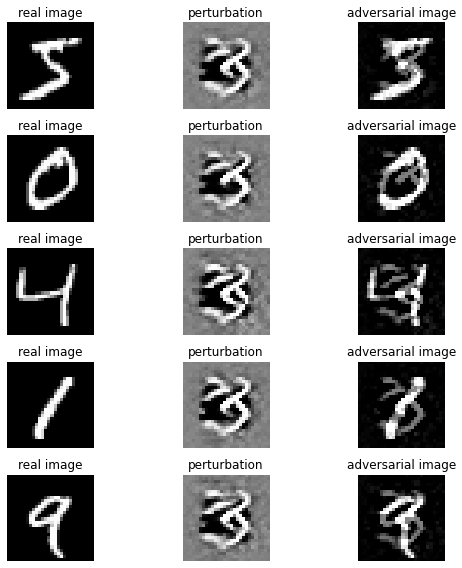

421/421 [==============================] - 18s 42ms/step - d_loss: 0.2013 - g_loss: 16.2363 - g_gan_loss: 2.8569 - g_adv_loss: 0.7012 - g_perturb_loss: 12.6783
Epoch 18/50
421/421 [==============================] - ETA: 0s - d_loss: 0.2013 - g_loss: 16.1052 - g_gan_loss: 2.8599 - g_adv_loss: 0.6447 - g_perturb_loss: 12.6007

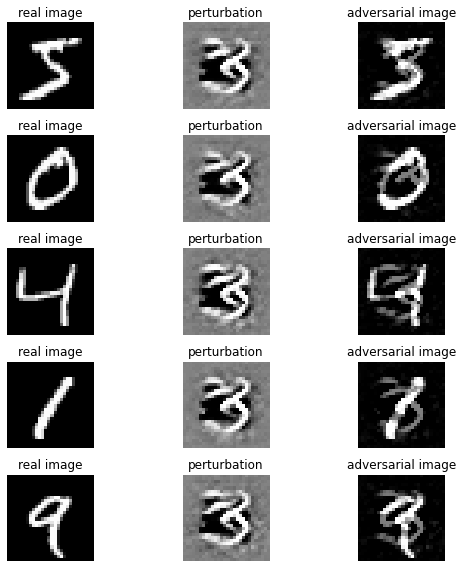

421/421 [==============================] - 18s 42ms/step - d_loss: 0.2013 - g_loss: 16.1065 - g_gan_loss: 2.8601 - g_adv_loss: 0.6462 - g_perturb_loss: 12.6002
Epoch 19/50
421/421 [==============================] - ETA: 0s - d_loss: 0.2011 - g_loss: 16.0766 - g_gan_loss: 2.8581 - g_adv_loss: 0.7219 - g_perturb_loss: 12.4967

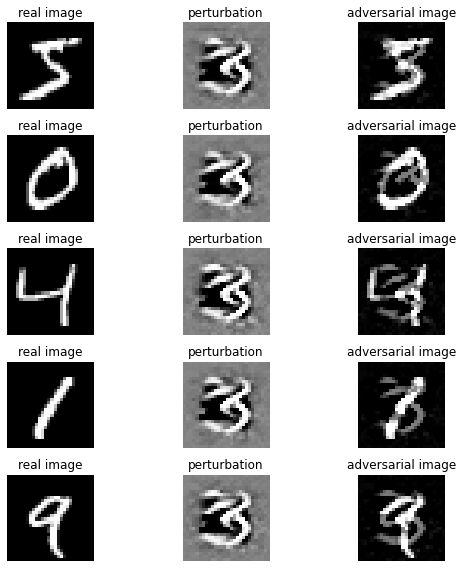

421/421 [==============================] - 18s 42ms/step - d_loss: 0.2011 - g_loss: 16.0749 - g_gan_loss: 2.8580 - g_adv_loss: 0.7205 - g_perturb_loss: 12.4965
Epoch 20/50
421/421 [==============================] - ETA: 0s - d_loss: 0.2010 - g_loss: 16.0237 - g_gan_loss: 2.8593 - g_adv_loss: 0.7347 - g_perturb_loss: 12.4297

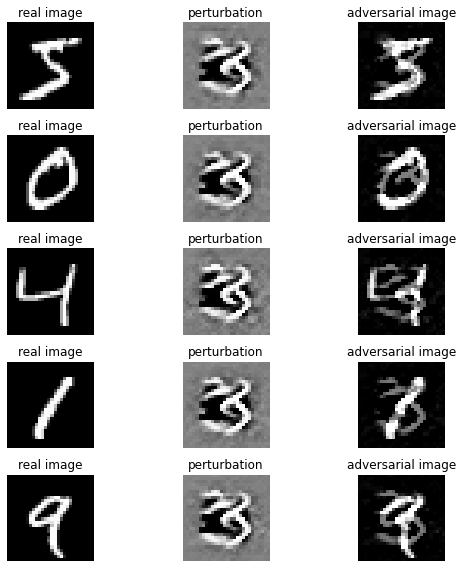

421/421 [==============================] - 18s 42ms/step - d_loss: 0.2010 - g_loss: 16.0218 - g_gan_loss: 2.8592 - g_adv_loss: 0.7331 - g_perturb_loss: 12.4295
Epoch 21/50
421/421 [==============================] - ETA: 0s - d_loss: 0.2007 - g_loss: 15.8717 - g_gan_loss: 2.8566 - g_adv_loss: 0.6694 - g_perturb_loss: 12.3457

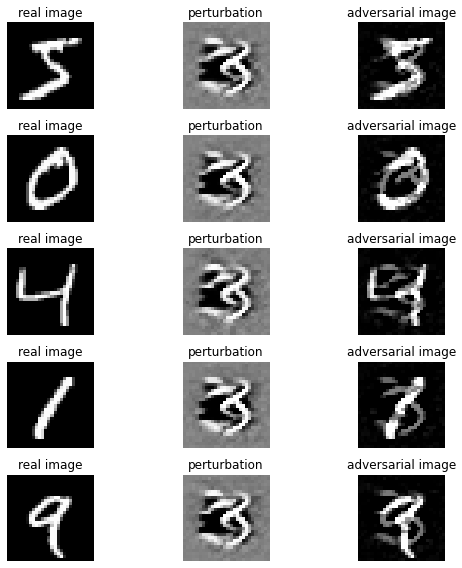

421/421 [==============================] - 18s 42ms/step - d_loss: 0.2007 - g_loss: 15.8701 - g_gan_loss: 2.8566 - g_adv_loss: 0.6678 - g_perturb_loss: 12.3457
Epoch 22/50
421/421 [==============================] - ETA: 0s - d_loss: 0.2008 - g_loss: 15.8496 - g_gan_loss: 2.8587 - g_adv_loss: 0.6873 - g_perturb_loss: 12.3035

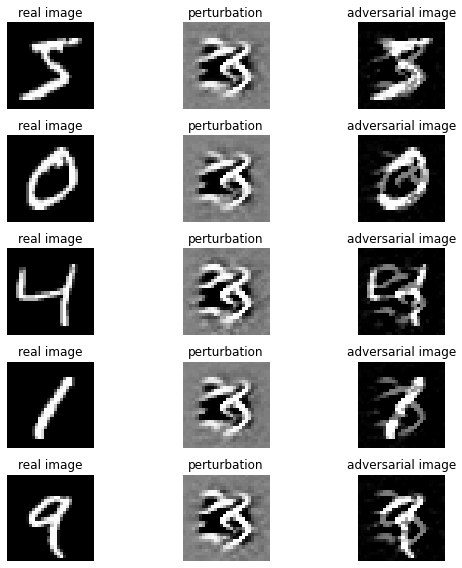

421/421 [==============================] - 18s 42ms/step - d_loss: 0.2008 - g_loss: 15.8490 - g_gan_loss: 2.8586 - g_adv_loss: 0.6861 - g_perturb_loss: 12.3043
Epoch 23/50
420/421 [============================>.] - ETA: 0s - d_loss: 0.2006 - g_loss: 15.7788 - g_gan_loss: 2.8570 - g_adv_loss: 0.6514 - g_perturb_loss: 12.2704

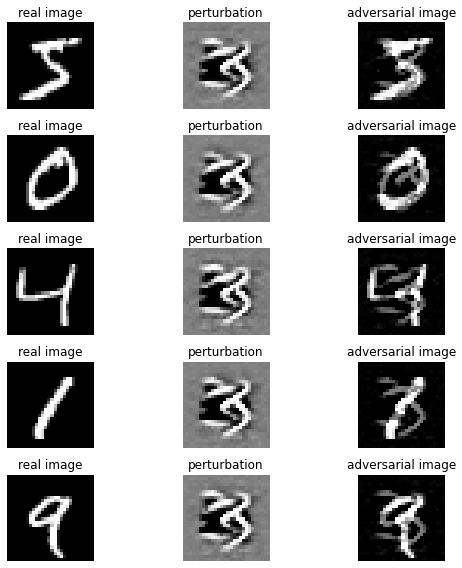

421/421 [==============================] - 18s 42ms/step - d_loss: 0.2006 - g_loss: 15.7791 - g_gan_loss: 2.8569 - g_adv_loss: 0.6526 - g_perturb_loss: 12.2696
Epoch 24/50
420/421 [============================>.] - ETA: 0s - d_loss: 0.2005 - g_loss: 15.7155 - g_gan_loss: 2.8559 - g_adv_loss: 0.6254 - g_perturb_loss: 12.2342

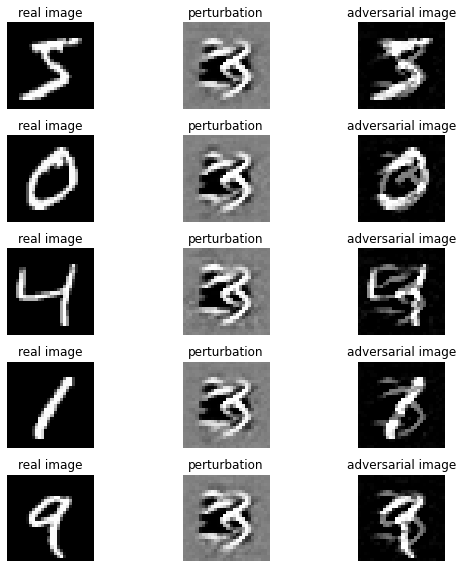

421/421 [==============================] - 18s 42ms/step - d_loss: 0.2005 - g_loss: 15.7174 - g_gan_loss: 2.8557 - g_adv_loss: 0.6272 - g_perturb_loss: 12.2345
Epoch 25/50
421/421 [==============================] - ETA: 0s - d_loss: 0.2004 - g_loss: 15.6888 - g_gan_loss: 2.8560 - g_adv_loss: 0.5842 - g_perturb_loss: 12.2485

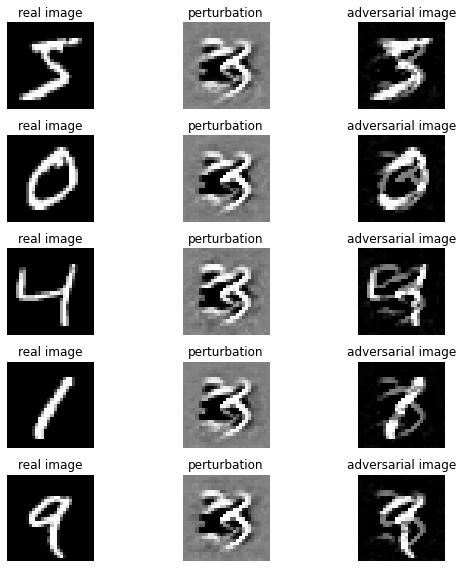

421/421 [==============================] - 18s 41ms/step - d_loss: 0.2004 - g_loss: 15.6875 - g_gan_loss: 2.8561 - g_adv_loss: 0.5830 - g_perturb_loss: 12.2483
Epoch 26/50
421/421 [==============================] - ETA: 0s - d_loss: 0.2004 - g_loss: 15.6914 - g_gan_loss: 2.8560 - g_adv_loss: 0.6225 - g_perturb_loss: 12.2129

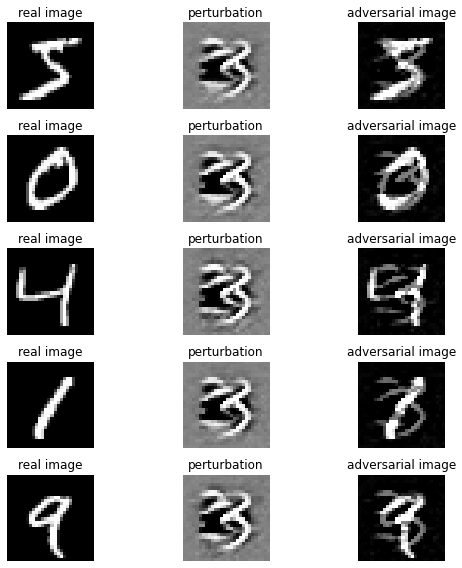

421/421 [==============================] - 18s 42ms/step - d_loss: 0.2004 - g_loss: 15.6918 - g_gan_loss: 2.8559 - g_adv_loss: 0.6231 - g_perturb_loss: 12.2128
Epoch 27/50
421/421 [==============================] - ETA: 0s - d_loss: 0.2004 - g_loss: 15.7153 - g_gan_loss: 2.8552 - g_adv_loss: 0.6189 - g_perturb_loss: 12.2411

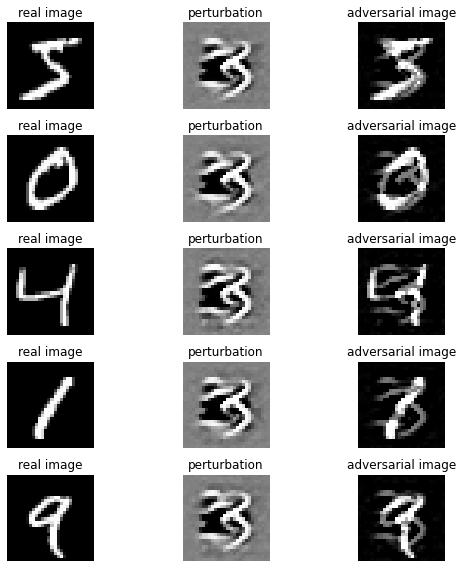

421/421 [==============================] - 18s 42ms/step - d_loss: 0.2004 - g_loss: 15.7150 - g_gan_loss: 2.8550 - g_adv_loss: 0.6188 - g_perturb_loss: 12.2412
Epoch 28/50
421/421 [==============================] - ETA: 0s - d_loss: 0.2004 - g_loss: 15.7257 - g_gan_loss: 2.8551 - g_adv_loss: 0.6230 - g_perturb_loss: 12.2476

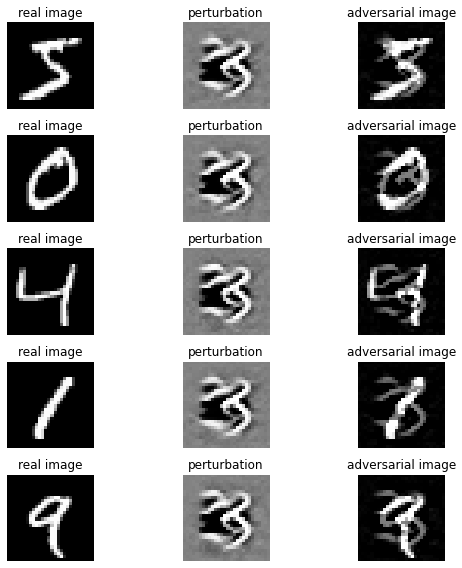

421/421 [==============================] - 18s 42ms/step - d_loss: 0.2004 - g_loss: 15.7267 - g_gan_loss: 2.8552 - g_adv_loss: 0.6242 - g_perturb_loss: 12.2473
Epoch 29/50
421/421 [==============================] - ETA: 0s - d_loss: 0.2004 - g_loss: 15.8524 - g_gan_loss: 2.8559 - g_adv_loss: 0.7394 - g_perturb_loss: 12.2571

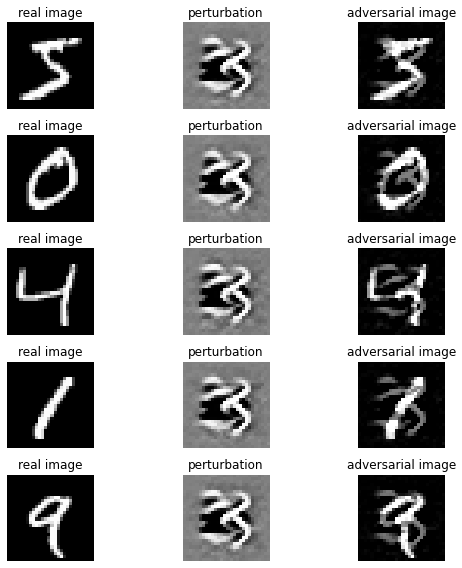

421/421 [==============================] - 18s 42ms/step - d_loss: 0.2004 - g_loss: 15.8514 - g_gan_loss: 2.8558 - g_adv_loss: 0.7381 - g_perturb_loss: 12.2575
Epoch 30/50
421/421 [==============================] - ETA: 0s - d_loss: 0.2005 - g_loss: 15.8733 - g_gan_loss: 2.8561 - g_adv_loss: 0.7056 - g_perturb_loss: 12.3116

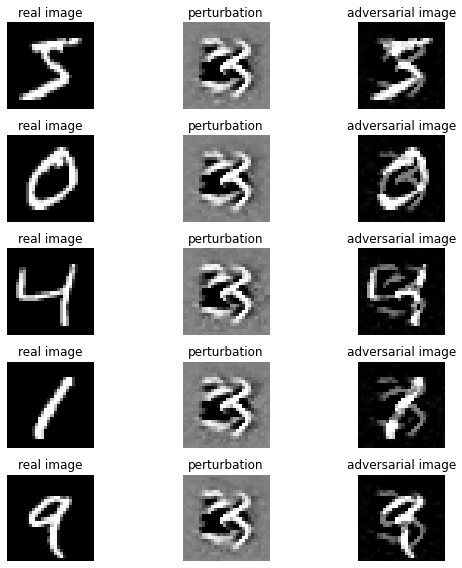

421/421 [==============================] - 18s 42ms/step - d_loss: 0.2005 - g_loss: 15.8754 - g_gan_loss: 2.8562 - g_adv_loss: 0.7079 - g_perturb_loss: 12.3114
Epoch 31/50
420/421 [============================>.] - ETA: 0s - d_loss: 0.2006 - g_loss: 15.8903 - g_gan_loss: 2.8564 - g_adv_loss: 0.6237 - g_perturb_loss: 12.4102

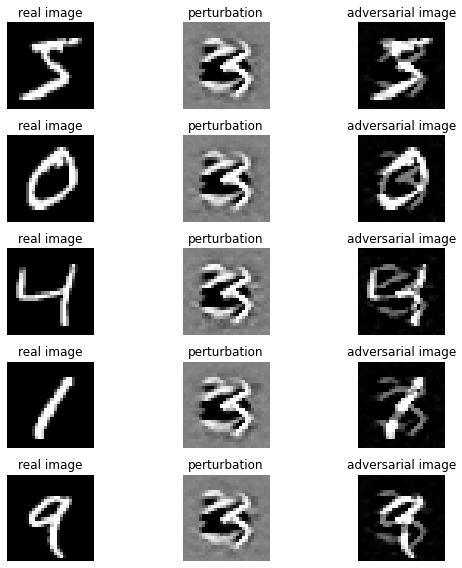

421/421 [==============================] - 18s 42ms/step - d_loss: 0.2006 - g_loss: 15.8897 - g_gan_loss: 2.8570 - g_adv_loss: 0.6236 - g_perturb_loss: 12.4091
Epoch 32/50
421/421 [==============================] - ETA: 0s - d_loss: 0.2006 - g_loss: 15.8704 - g_gan_loss: 2.8570 - g_adv_loss: 0.6538 - g_perturb_loss: 12.3596

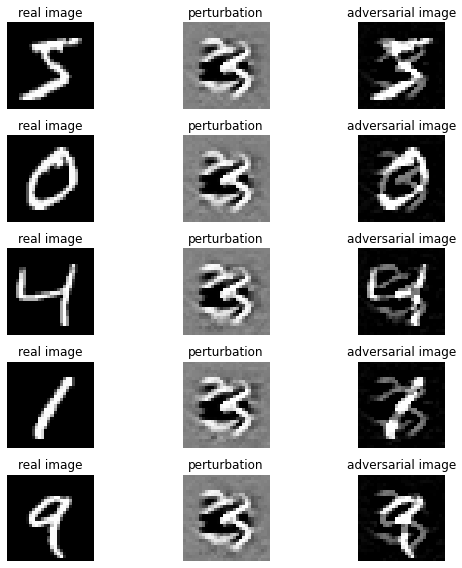

421/421 [==============================] - 18s 42ms/step - d_loss: 0.2006 - g_loss: 15.8692 - g_gan_loss: 2.8571 - g_adv_loss: 0.6523 - g_perturb_loss: 12.3598
Epoch 33/50
420/421 [============================>.] - ETA: 0s - d_loss: 0.2006 - g_loss: 15.8928 - g_gan_loss: 2.8550 - g_adv_loss: 0.6999 - g_perturb_loss: 12.3379

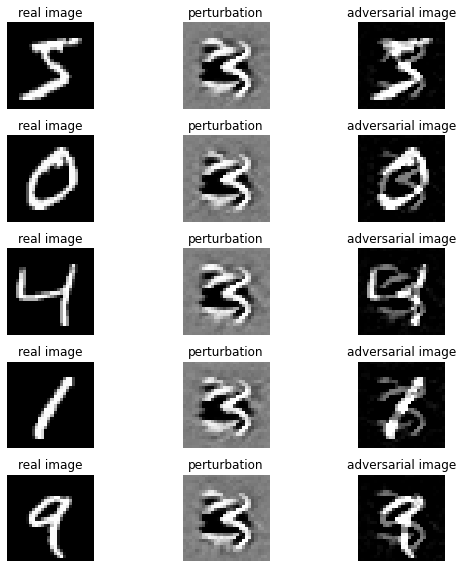

421/421 [==============================] - 18s 42ms/step - d_loss: 0.2006 - g_loss: 15.8996 - g_gan_loss: 2.8548 - g_adv_loss: 0.7071 - g_perturb_loss: 12.3377
Epoch 34/50
421/421 [==============================] - ETA: 0s - d_loss: 0.2007 - g_loss: 15.9363 - g_gan_loss: 2.8564 - g_adv_loss: 0.7309 - g_perturb_loss: 12.3491

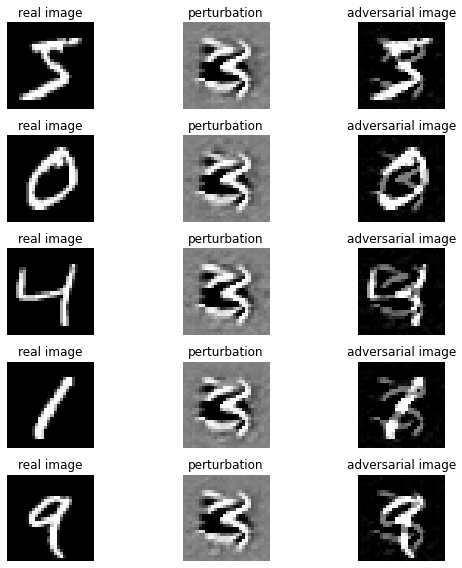

421/421 [==============================] - 18s 42ms/step - d_loss: 0.2007 - g_loss: 15.9351 - g_gan_loss: 2.8565 - g_adv_loss: 0.7291 - g_perturb_loss: 12.3495
Epoch 35/50
420/421 [============================>.] - ETA: 0s - d_loss: 0.2005 - g_loss: 15.8726 - g_gan_loss: 2.8563 - g_adv_loss: 0.6947 - g_perturb_loss: 12.3216

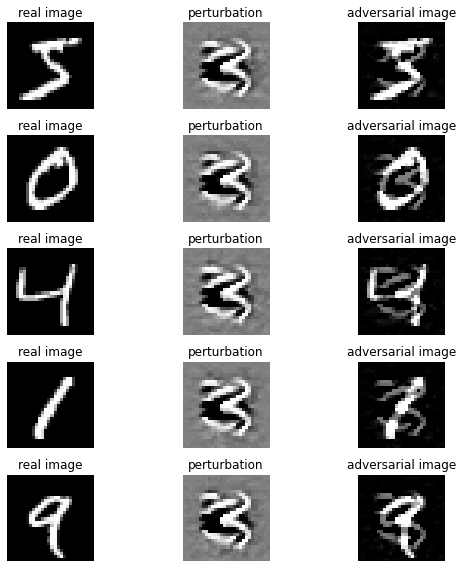

421/421 [==============================] - 18s 42ms/step - d_loss: 0.2005 - g_loss: 15.8696 - g_gan_loss: 2.8565 - g_adv_loss: 0.6918 - g_perturb_loss: 12.3213
Epoch 36/50
421/421 [==============================] - ETA: 0s - d_loss: 0.2007 - g_loss: 15.9049 - g_gan_loss: 2.8568 - g_adv_loss: 0.7161 - g_perturb_loss: 12.3319

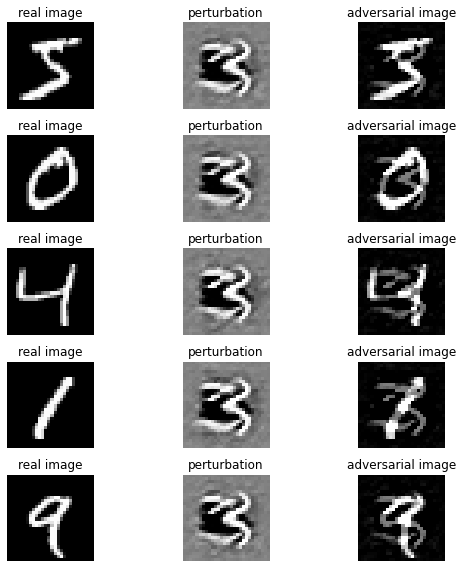

421/421 [==============================] - 18s 43ms/step - d_loss: 0.2007 - g_loss: 15.9072 - g_gan_loss: 2.8568 - g_adv_loss: 0.7185 - g_perturb_loss: 12.3319
Epoch 37/50
420/421 [============================>.] - ETA: 0s - d_loss: 0.2010 - g_loss: 15.8240 - g_gan_loss: 2.8571 - g_adv_loss: 0.6886 - g_perturb_loss: 12.2783

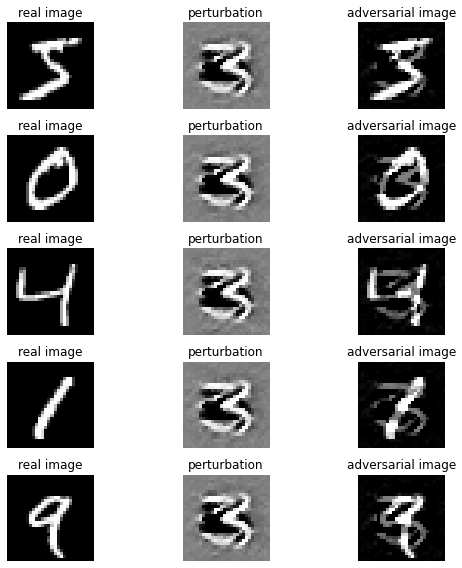

421/421 [==============================] - 18s 42ms/step - d_loss: 0.2010 - g_loss: 15.8232 - g_gan_loss: 2.8575 - g_adv_loss: 0.6875 - g_perturb_loss: 12.2782
Epoch 38/50
421/421 [==============================] - ETA: 0s - d_loss: 0.2010 - g_loss: 15.7676 - g_gan_loss: 2.8586 - g_adv_loss: 0.6945 - g_perturb_loss: 12.2145

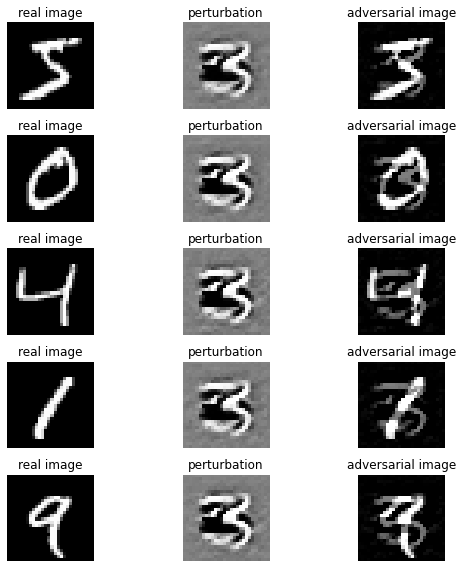

421/421 [==============================] - 18s 42ms/step - d_loss: 0.2010 - g_loss: 15.7670 - g_gan_loss: 2.8589 - g_adv_loss: 0.6935 - g_perturb_loss: 12.2146
Epoch 39/50
421/421 [==============================] - ETA: 0s - d_loss: 0.2008 - g_loss: 15.6380 - g_gan_loss: 2.8577 - g_adv_loss: 0.6907 - g_perturb_loss: 12.0896

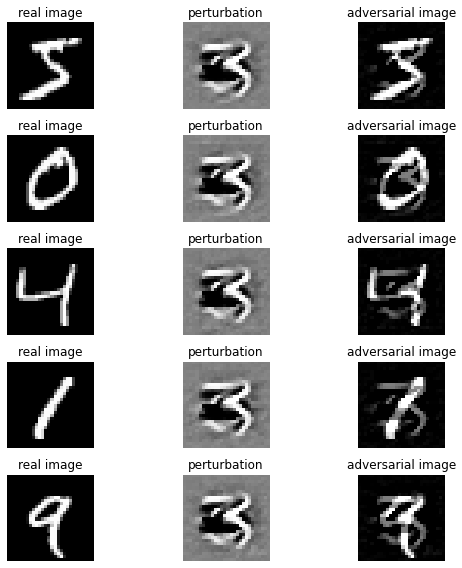

421/421 [==============================] - 18s 42ms/step - d_loss: 0.2008 - g_loss: 15.6363 - g_gan_loss: 2.8577 - g_adv_loss: 0.6891 - g_perturb_loss: 12.0895
Epoch 40/50
420/421 [============================>.] - ETA: 0s - d_loss: 0.2009 - g_loss: 15.7047 - g_gan_loss: 2.8575 - g_adv_loss: 0.6707 - g_perturb_loss: 12.1765

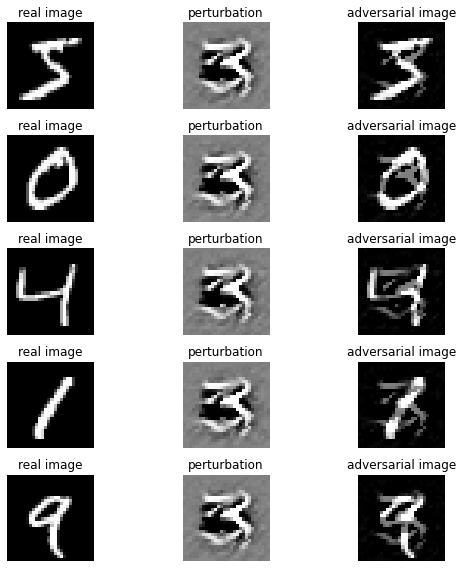

421/421 [==============================] - 18s 43ms/step - d_loss: 0.2009 - g_loss: 15.7051 - g_gan_loss: 2.8572 - g_adv_loss: 0.6715 - g_perturb_loss: 12.1764
Epoch 41/50
421/421 [==============================] - ETA: 0s - d_loss: 0.2014 - g_loss: 15.9171 - g_gan_loss: 2.8578 - g_adv_loss: 0.7329 - g_perturb_loss: 12.3264

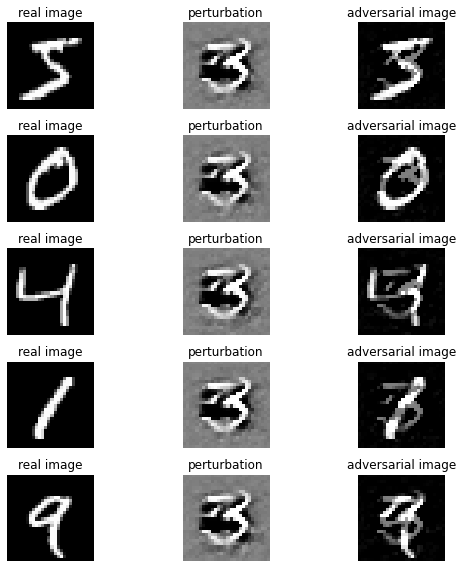

421/421 [==============================] - 18s 42ms/step - d_loss: 0.2014 - g_loss: 15.9160 - g_gan_loss: 2.8578 - g_adv_loss: 0.7322 - g_perturb_loss: 12.3260
Epoch 42/50
420/421 [============================>.] - ETA: 0s - d_loss: 0.2013 - g_loss: 15.8730 - g_gan_loss: 2.8610 - g_adv_loss: 0.7506 - g_perturb_loss: 12.2613

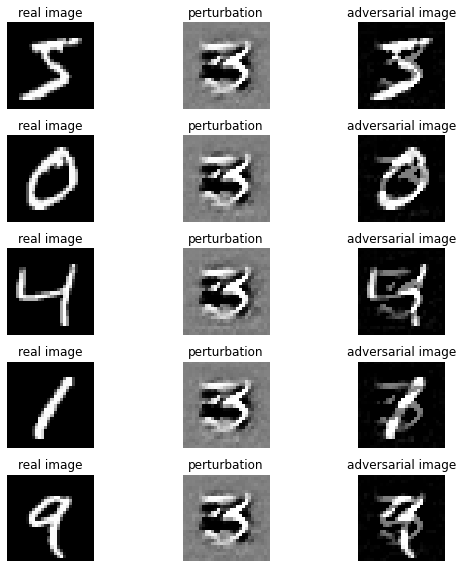

421/421 [==============================] - 18s 42ms/step - d_loss: 0.2013 - g_loss: 15.8700 - g_gan_loss: 2.8613 - g_adv_loss: 0.7481 - g_perturb_loss: 12.2606
Epoch 43/50
421/421 [==============================] - ETA: 0s - d_loss: 0.2011 - g_loss: 15.6860 - g_gan_loss: 2.8593 - g_adv_loss: 0.7841 - g_perturb_loss: 12.0426

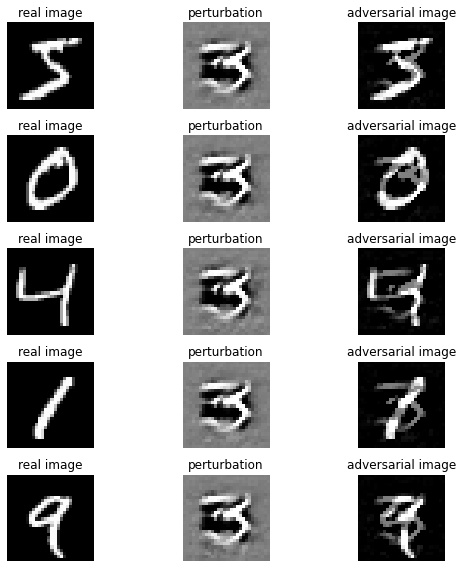

421/421 [==============================] - 18s 42ms/step - d_loss: 0.2011 - g_loss: 15.6853 - g_gan_loss: 2.8594 - g_adv_loss: 0.7832 - g_perturb_loss: 12.0427
Epoch 44/50
421/421 [==============================] - ETA: 0s - d_loss: 0.2012 - g_loss: 15.8171 - g_gan_loss: 2.8584 - g_adv_loss: 0.7736 - g_perturb_loss: 12.1850

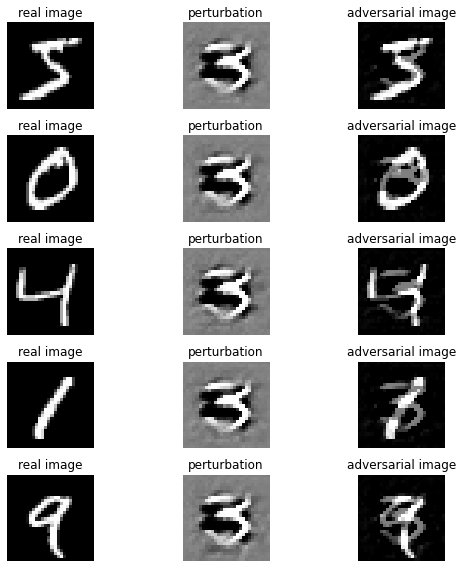

421/421 [==============================] - 18s 42ms/step - d_loss: 0.2012 - g_loss: 15.8187 - g_gan_loss: 2.8585 - g_adv_loss: 0.7750 - g_perturb_loss: 12.1852
Epoch 45/50
420/421 [============================>.] - ETA: 0s - d_loss: 0.2013 - g_loss: 15.8689 - g_gan_loss: 2.8607 - g_adv_loss: 0.7344 - g_perturb_loss: 12.2737

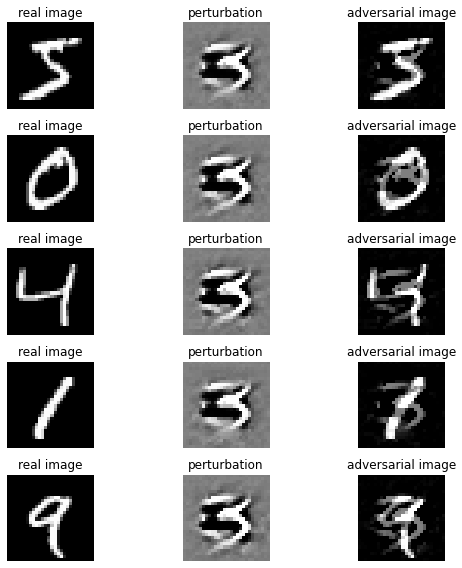

421/421 [==============================] - 18s 42ms/step - d_loss: 0.2013 - g_loss: 15.8684 - g_gan_loss: 2.8607 - g_adv_loss: 0.7340 - g_perturb_loss: 12.2737
Epoch 46/50
421/421 [==============================] - ETA: 0s - d_loss: 0.2009 - g_loss: 15.7596 - g_gan_loss: 2.8601 - g_adv_loss: 0.7045 - g_perturb_loss: 12.1950

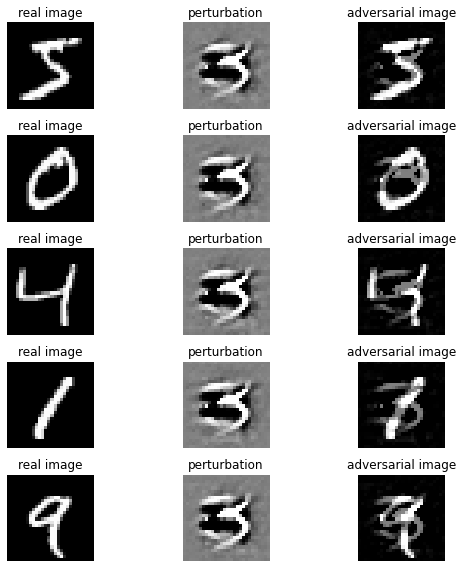

421/421 [==============================] - 18s 42ms/step - d_loss: 0.2009 - g_loss: 15.7587 - g_gan_loss: 2.8600 - g_adv_loss: 0.7033 - g_perturb_loss: 12.1954
Epoch 47/50
420/421 [============================>.] - ETA: 0s - d_loss: 0.2008 - g_loss: 15.7571 - g_gan_loss: 2.8593 - g_adv_loss: 0.7446 - g_perturb_loss: 12.1532

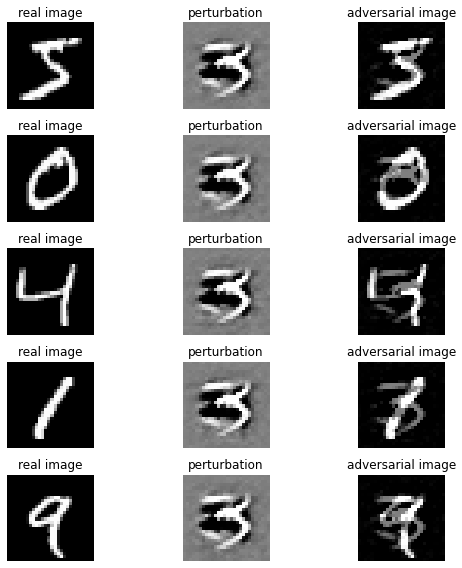

421/421 [==============================] - 18s 42ms/step - d_loss: 0.2009 - g_loss: 15.7525 - g_gan_loss: 2.8592 - g_adv_loss: 0.7411 - g_perturb_loss: 12.1521
Epoch 48/50
421/421 [==============================] - ETA: 0s - d_loss: 0.2009 - g_loss: 15.8033 - g_gan_loss: 2.8576 - g_adv_loss: 0.7943 - g_perturb_loss: 12.1514

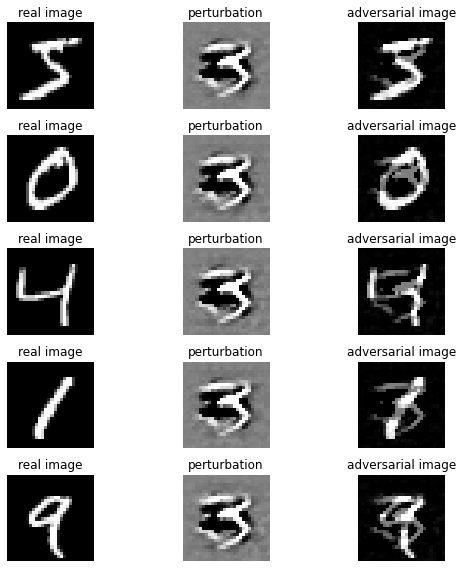

421/421 [==============================] - 18s 42ms/step - d_loss: 0.2009 - g_loss: 15.8020 - g_gan_loss: 2.8577 - g_adv_loss: 0.7930 - g_perturb_loss: 12.1513
Epoch 49/50
421/421 [==============================] - ETA: 0s - d_loss: 0.2008 - g_loss: 15.7788 - g_gan_loss: 2.8595 - g_adv_loss: 0.7696 - g_perturb_loss: 12.1497

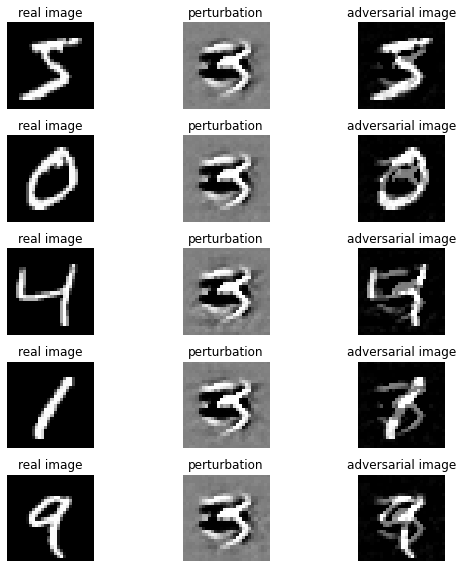

421/421 [==============================] - 21s 49ms/step - d_loss: 0.2008 - g_loss: 15.7789 - g_gan_loss: 2.8593 - g_adv_loss: 0.7699 - g_perturb_loss: 12.1497
Epoch 50/50
420/421 [============================>.] - ETA: 0s - d_loss: 0.2007 - g_loss: 15.6994 - g_gan_loss: 2.8580 - g_adv_loss: 0.7073 - g_perturb_loss: 12.1342

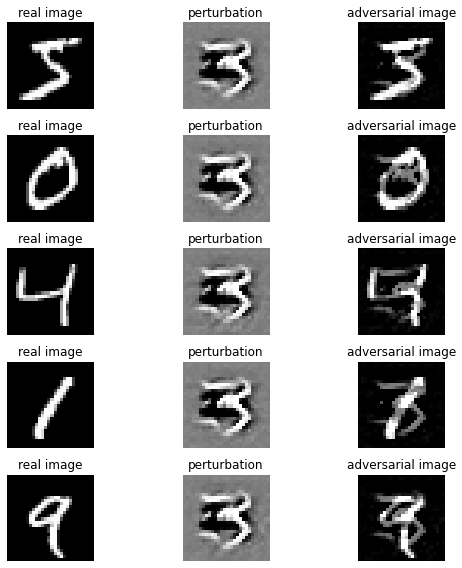

421/421 [==============================] - 18s 42ms/step - d_loss: 0.2007 - g_loss: 15.6988 - g_gan_loss: 2.8582 - g_adv_loss: 0.7067 - g_perturb_loss: 12.1340


In [ ]:
history = advdcgan.fit(
    dataset,
    epochs=50,
    callbacks=[callback]
)

In [ ]:
weights_path = f'{WEIGHTS_DIR}/{BASE_FILENAME}_{time.strftime("%Y%m%d%H%M%S")}.h5'
advdcgan.save_weights(weights_path)

print(f'Weights saved as {weights_path}')

Weights saved as weights/advdcgan_mnist_20220603125653.h5


In [ ]:
weights_path = f'{WEIGHTS_DIR}/{BASE_FILENAME}_g_{time.strftime("%Y%m%d%H%M%S")}.h5'
generator.save_weights(weights_path)

print(f'Weights saved as {weights_path}')

Weights saved as weights/advdcgan_mnist_g_20220603125653.h5


Plot the generator and discriminator losses through the epochs:

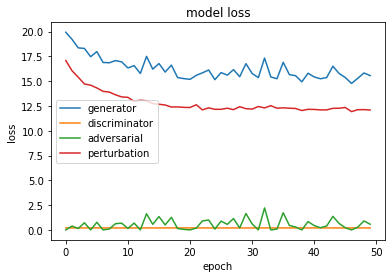

In [ ]:
plt.plot(history.history['g_loss'])
plt.plot(history.history['d_loss'])
plt.plot(history.history['g_adv_loss'])
plt.plot(history.history['g_perturb_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['generator', 'discriminator', 'adversarial', 'perturbation'], loc='best')

plt.show()

Plot the generator's progress through the epochs:


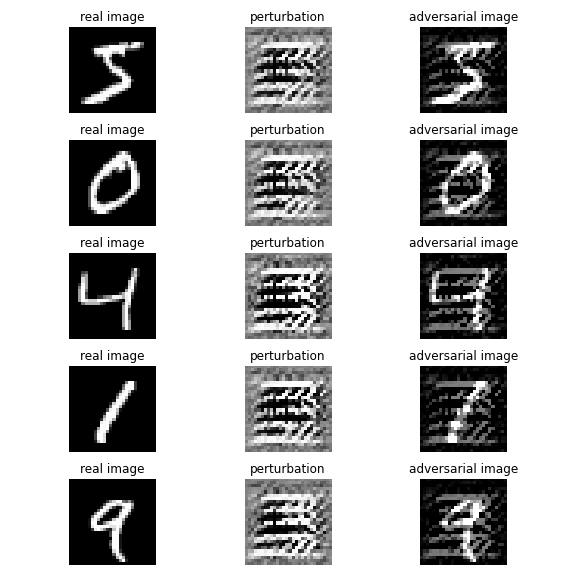

In [ ]:
import tensorflow_docs.vis.embed as embed

image_pattern = f'{IMAGES_DIR}/{BASE_FILENAME}*.png'
gif_path = f'{IMAGES_DIR}/{BASE_FILENAME}.gif'

images_to_gif(image_pattern, gif_path, delete_frames=True)
embed.embed_file(gif_path)

### Classifying generated images using `MNISTConvTarget`

We'll test the generator's performance by classifying the adversarial images it creates using the `MNISTConvTarget` model.

In [ ]:
adv_images, perturbations = generate_adv_examples(
    generator,
    test_images,
    latent_dim=LATENT_DIM,
    perturb_bound=PERTURB_BOUND
)

In [ ]:
probs = target.predict(adv_images)

In [ ]:
predictions = probs.argmax(axis=1)

Display and classify adversarial images obtained for a sample of 5 images:

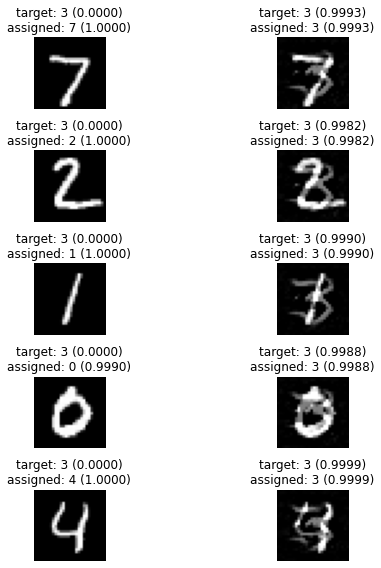

In [ ]:
plot_image_results(
    test_images[:5],
    adv_images[:5],
    target,
    TARGET_LABEL
)

#### Attack success rate

In [ ]:
asr = (predictions == TARGET_LABEL).sum() / len(predictions)

print(f'Attack success rate: {asr * 100:.2f}%')

Attack success rate: 98.83%


#### Average probability of target prediction

In [ ]:
avg_prob = probs[:, TARGET_LABEL].mean()

print(f'Average probability of predicting "{TARGET_LABEL}": {avg_prob:.4f}')

Average probability of predicting "3": 0.9752


#### Average perturbation strength ($L_2$-norm)

In [ ]:
reshaped = tf.reshape(perturbations, (perturbations.shape[0], -1))
avg_perturb_strength = tf.reduce_mean(tf.norm(reshaped, axis=1)).numpy()

print(f'Average perturbation strength: {avg_perturb_strength:.4f}')

Average perturbation strength: 12.2186


#### Attack confusion matrix

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


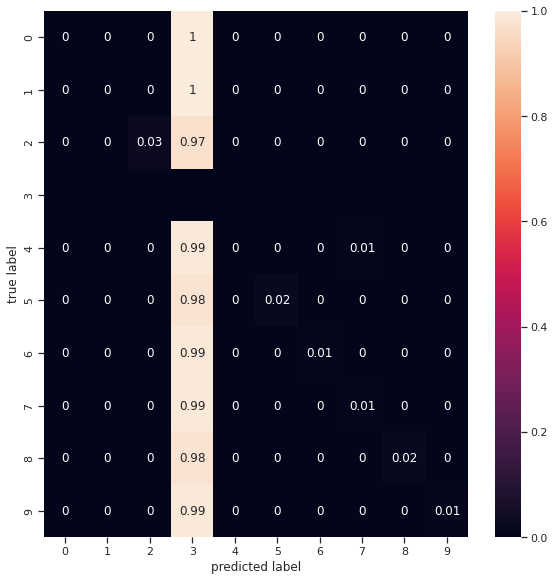

In [ ]:
plot_confusion_matrix(
    test_labels,
    predictions,
    classes=range(10),
    ignore_idx=TARGET_LABEL
)